In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import catboost
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pickle
from utils import *

pd.options.display.max_columns = 100

In [2]:
with open('models_month_clas.pkl', 'rb') as f:
    clas_month_model = pickle.load(f)
    
with open('models_quart_clas.pkl', 'rb') as f:
    clas_quart = pickle.load(f)

In [3]:
with open('models_month_reg.pkl', 'rb') as f:
    models_month_reg = pickle.load(f)
    
with open('models_quart_reg.pkl', 'rb') as f:
    models_quart_reg = pickle.load(f)

In [4]:
plt.rcParams["figure.figsize"] = (14,7)

  0%|          | 0/10 [00:00<?, ?it/s]

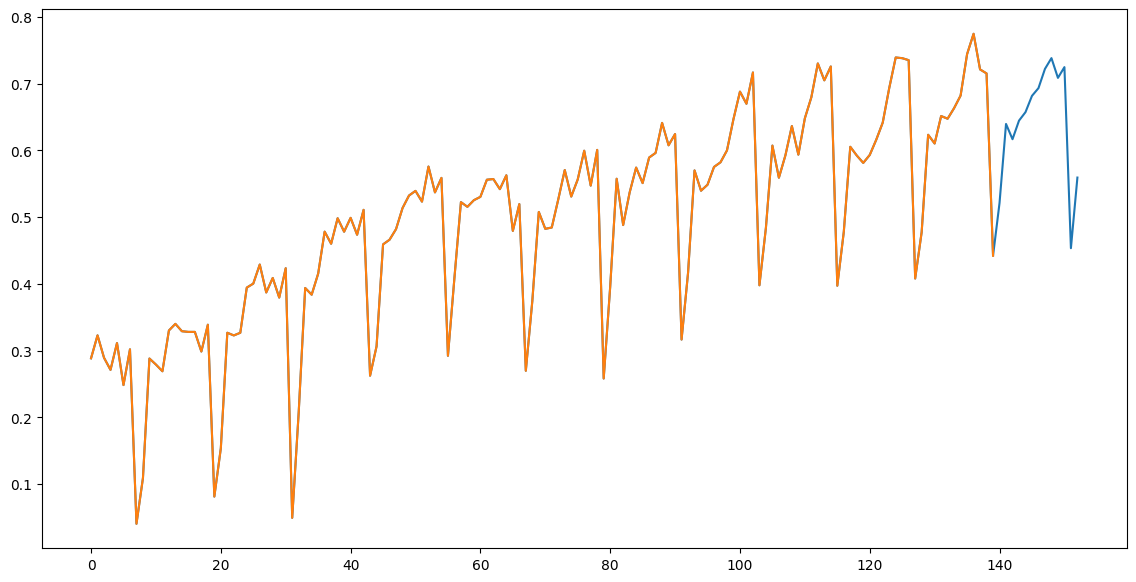

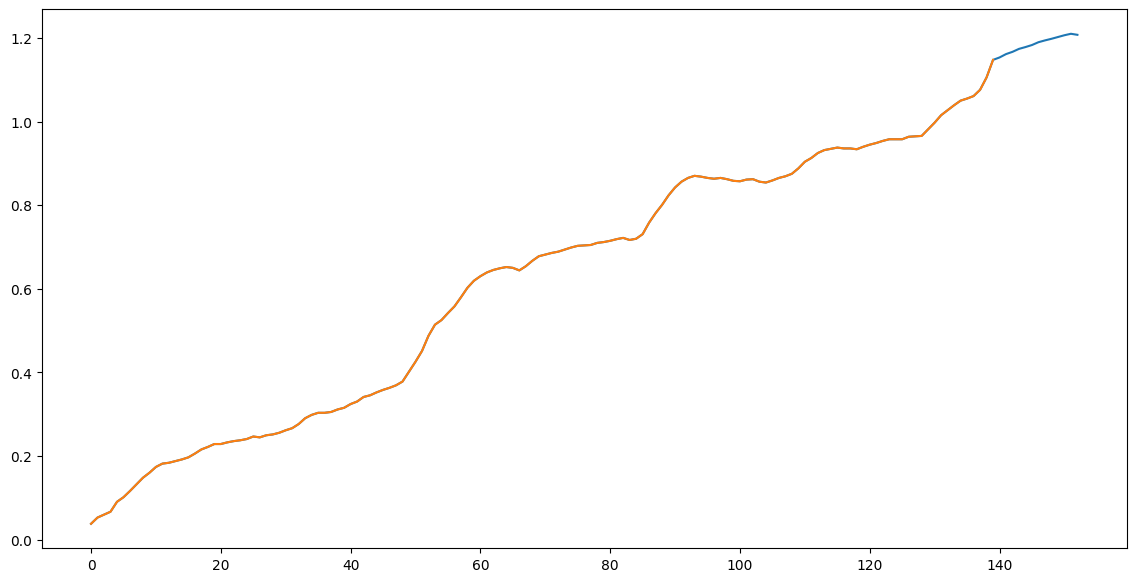

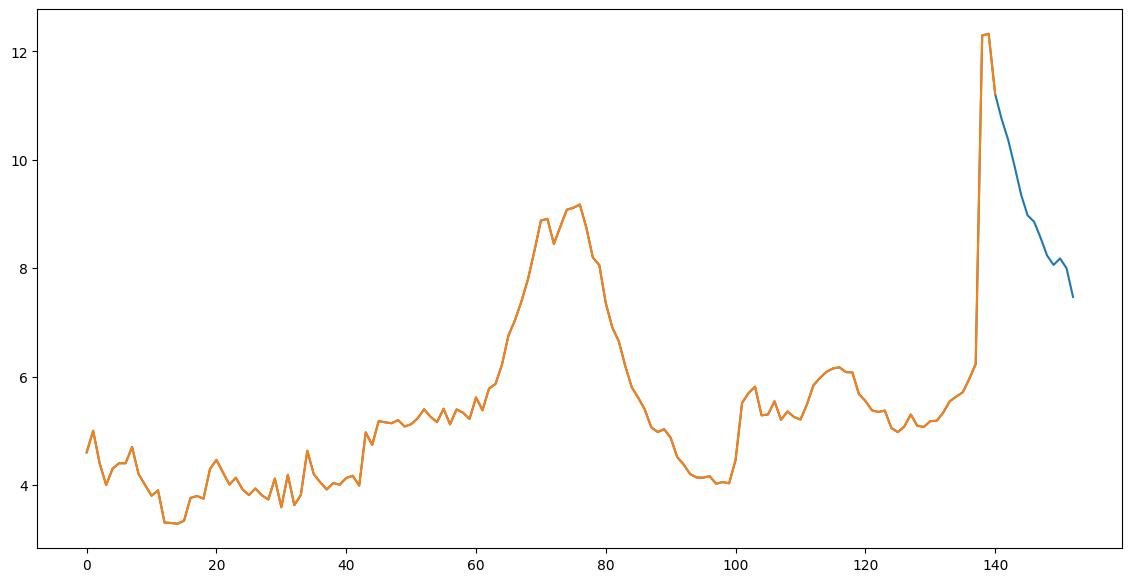

 10%|█         | 1/10 [00:00<00:06,  1.36it/s]

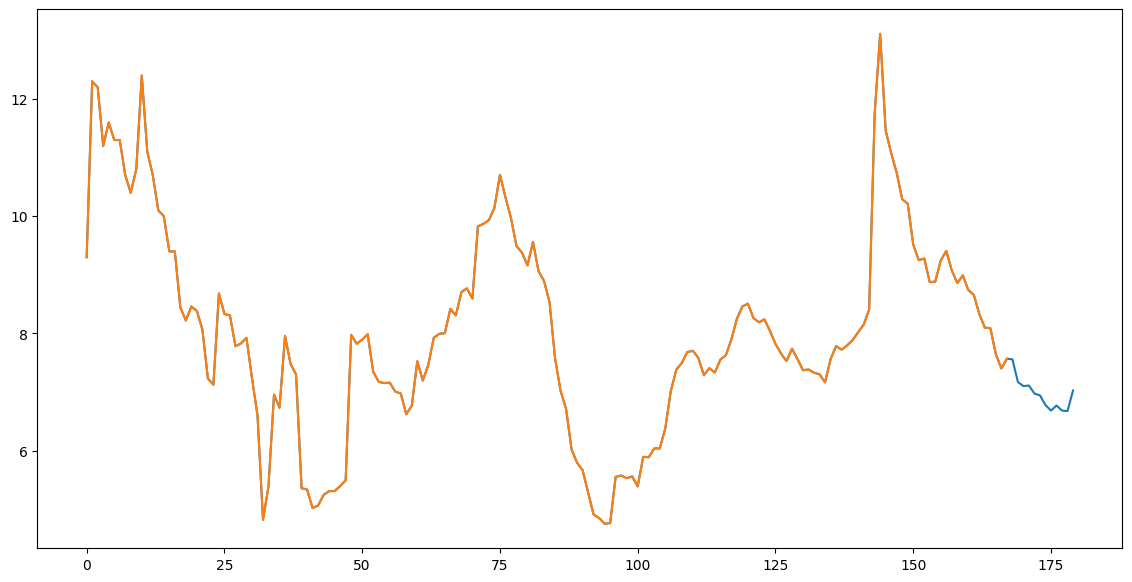

 30%|███       | 3/10 [00:01<00:02,  3.12it/s]

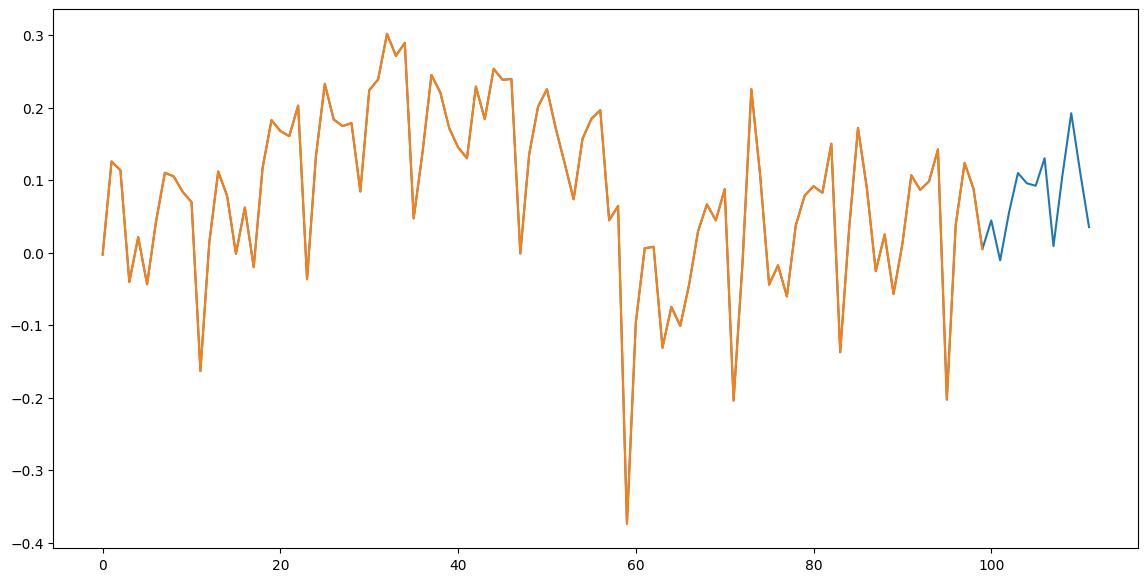

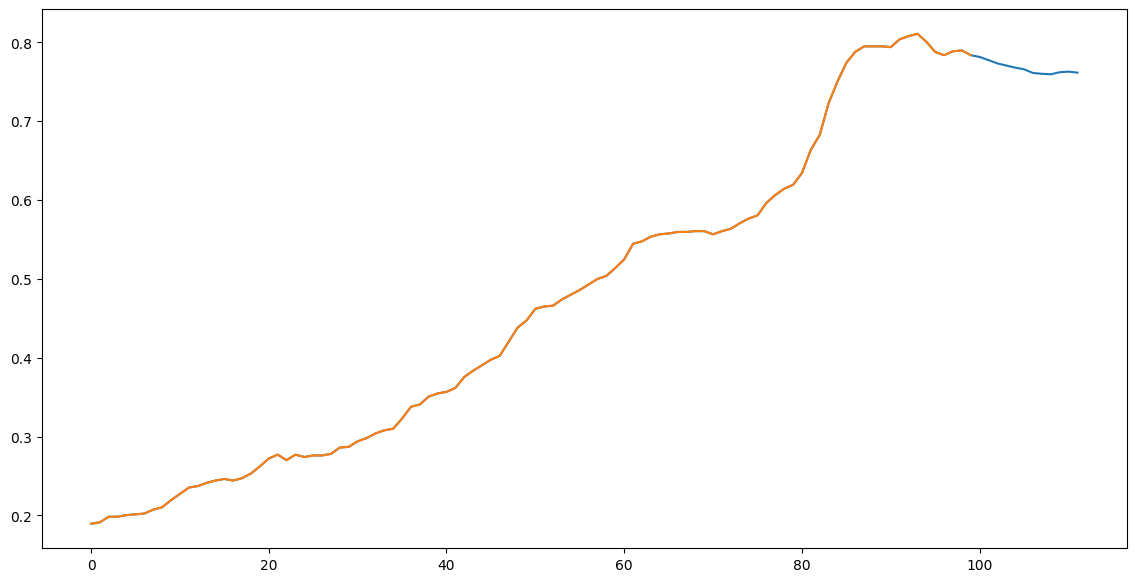

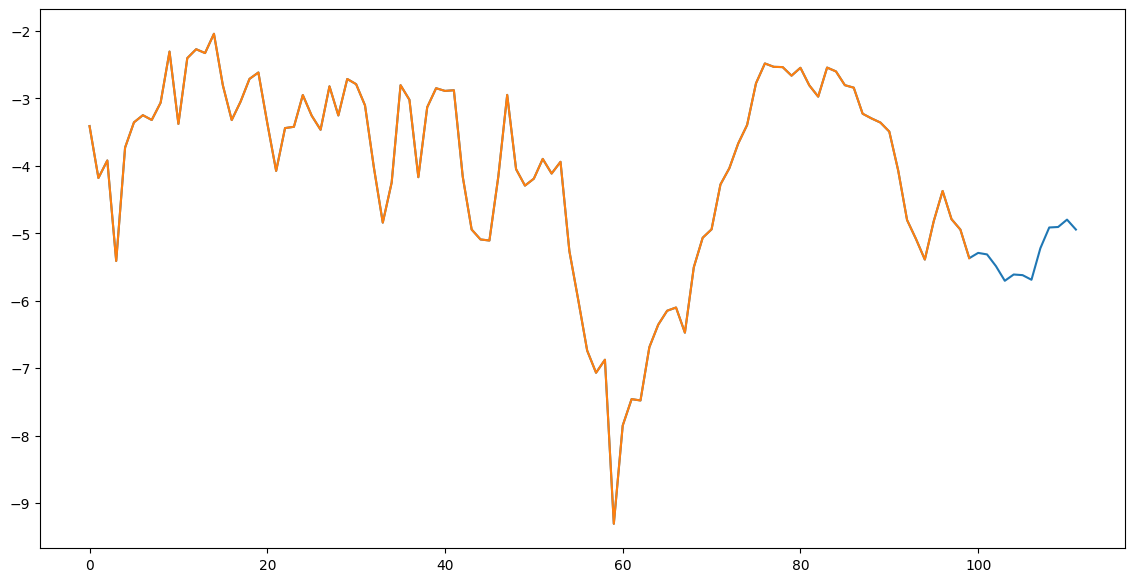

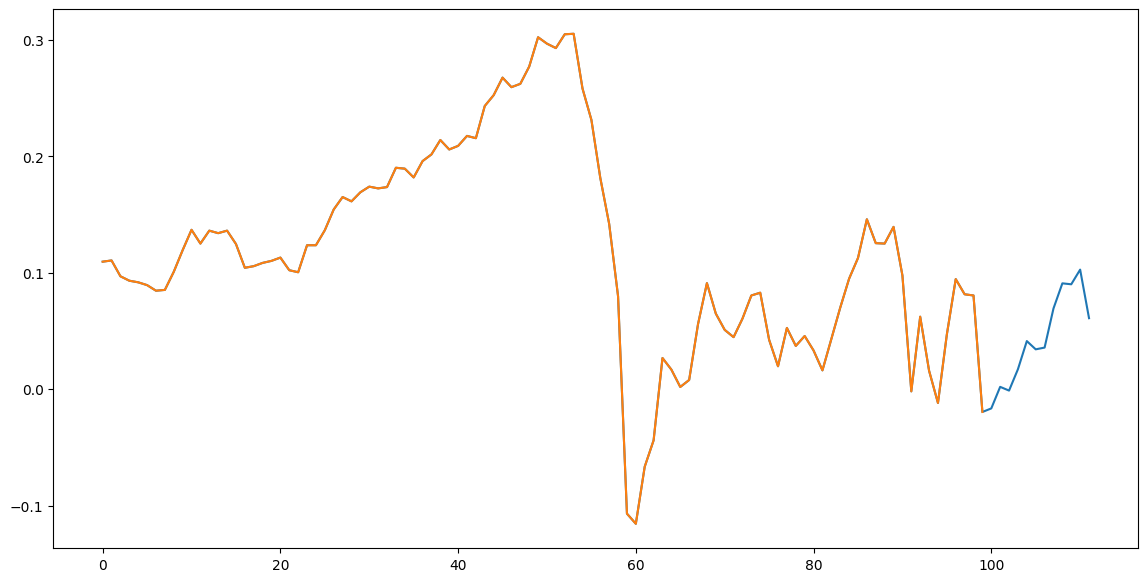

 40%|████      | 4/10 [00:01<00:02,  2.17it/s]

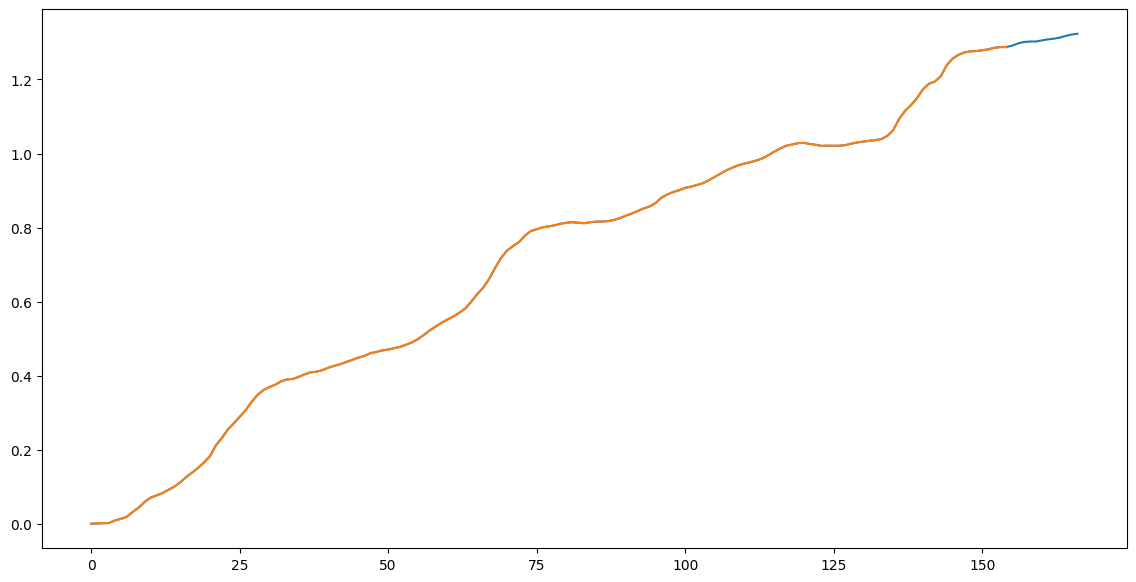

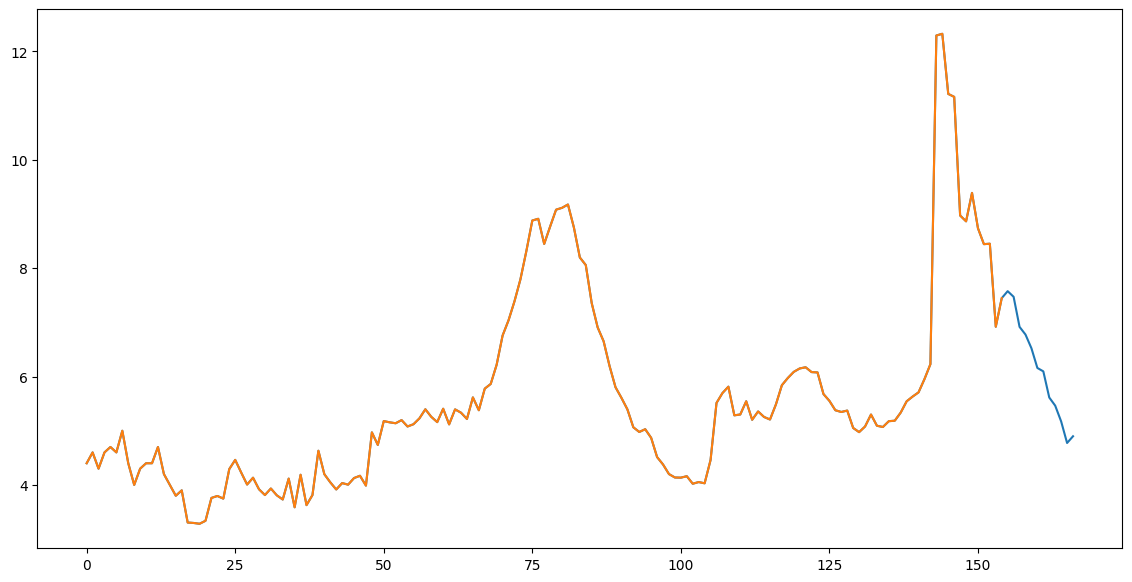

 50%|█████     | 5/10 [00:02<00:02,  1.97it/s]

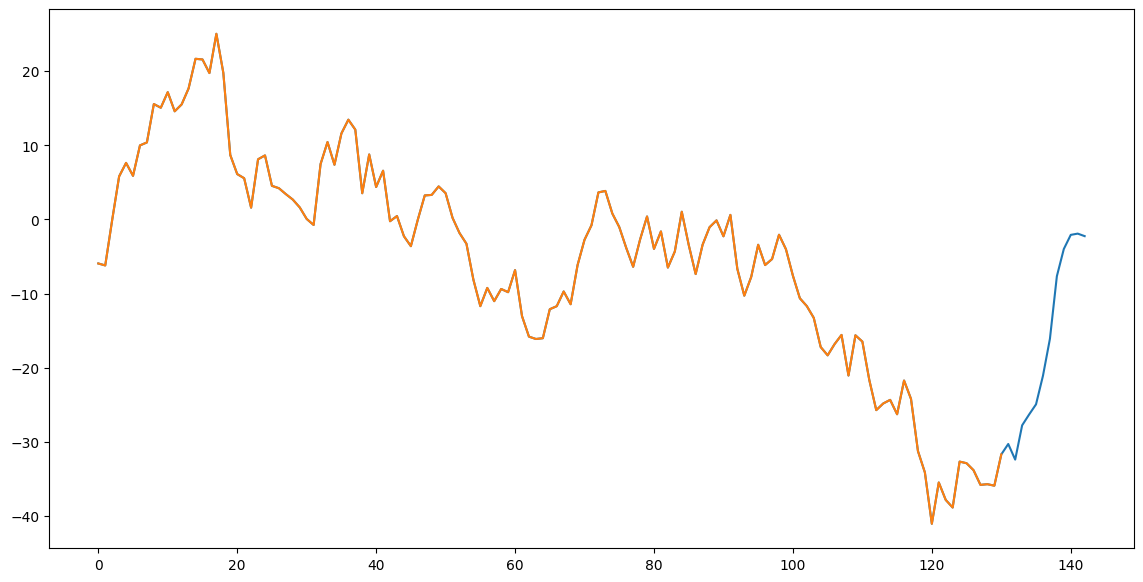

 60%|██████    | 6/10 [00:02<00:01,  2.54it/s]

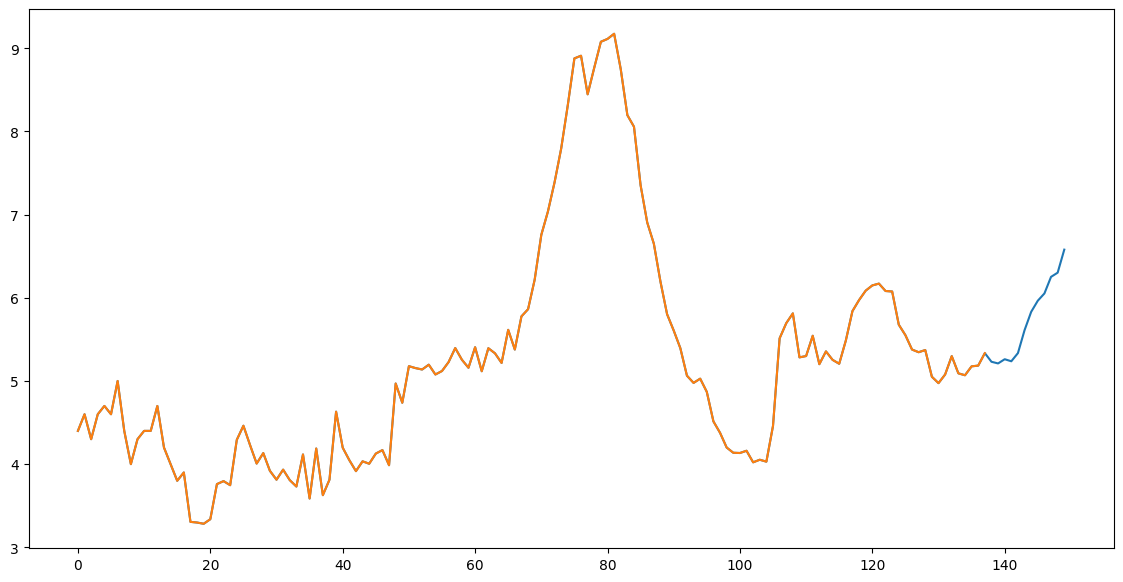

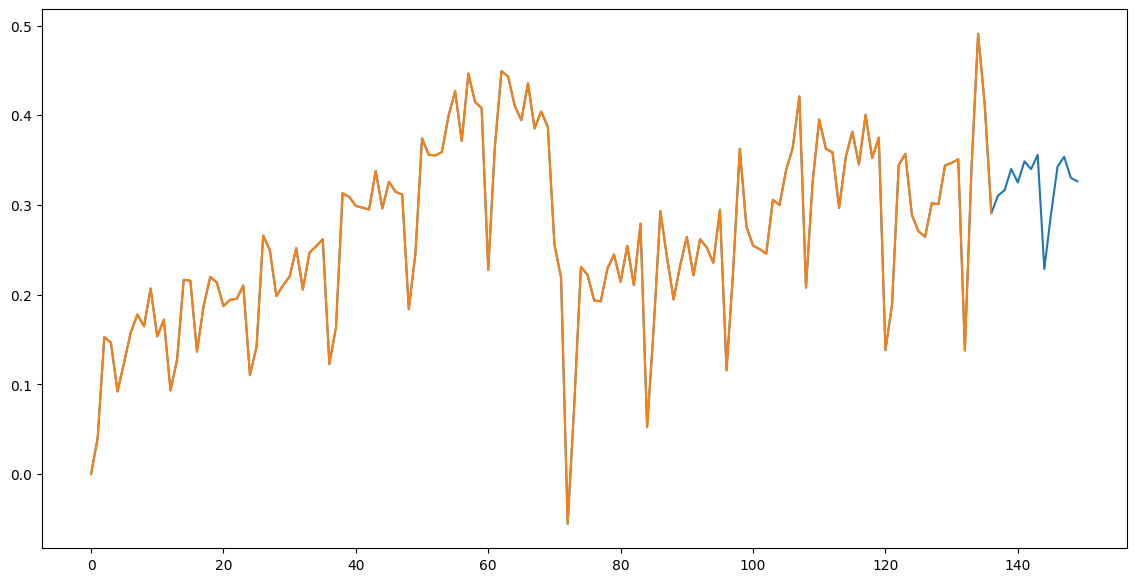

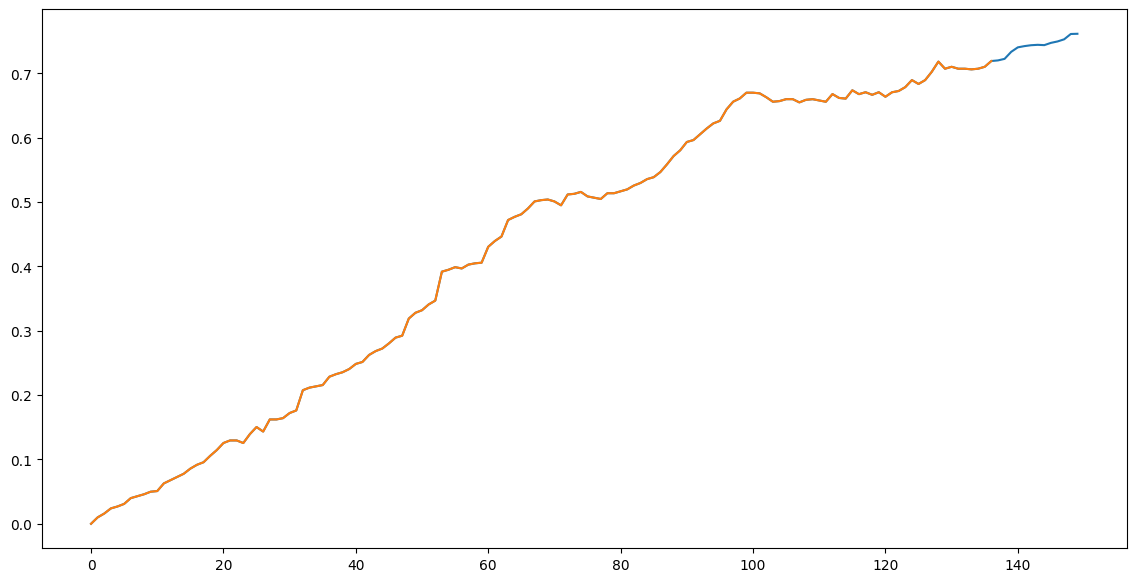

 70%|███████   | 7/10 [00:03<00:01,  2.32it/s]

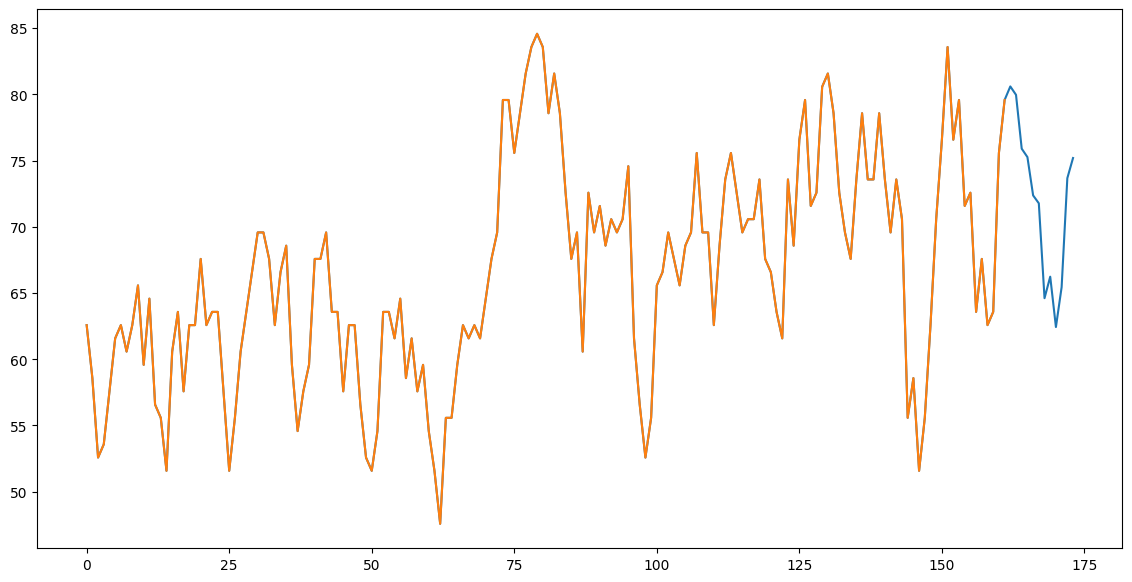

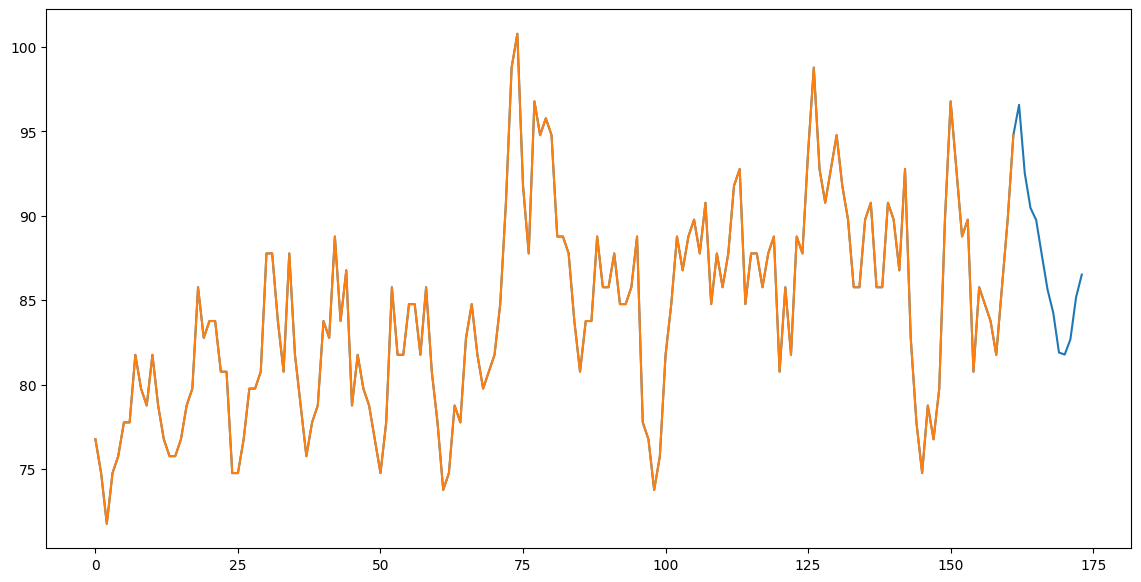

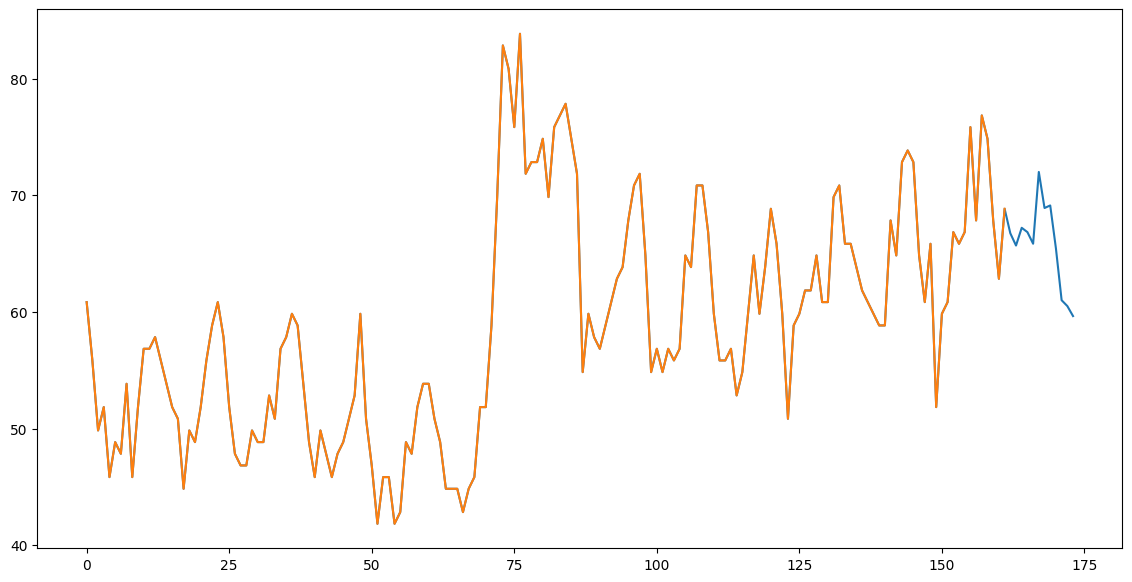

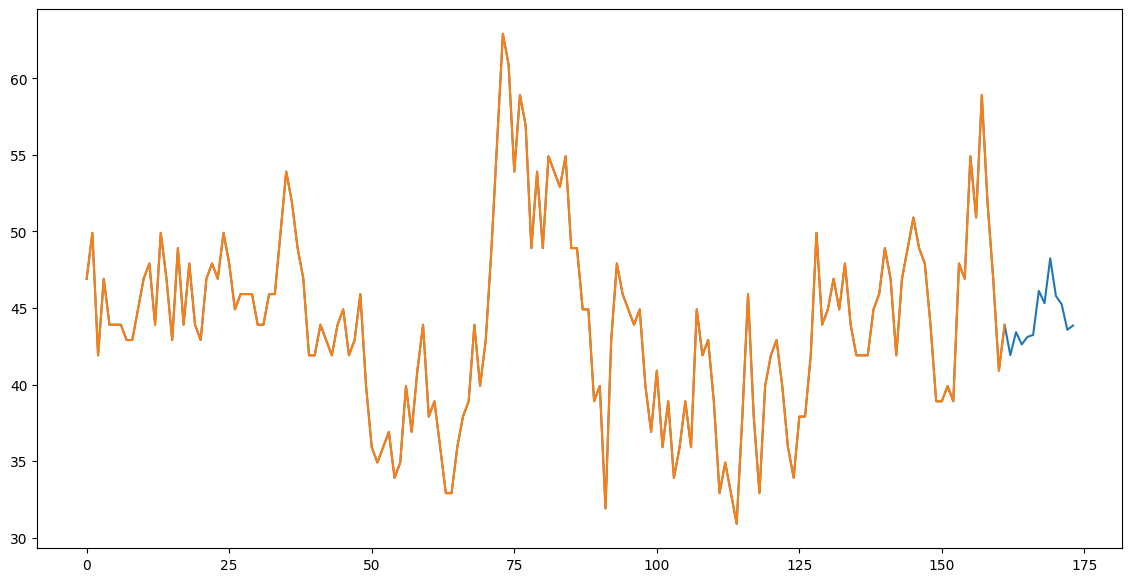

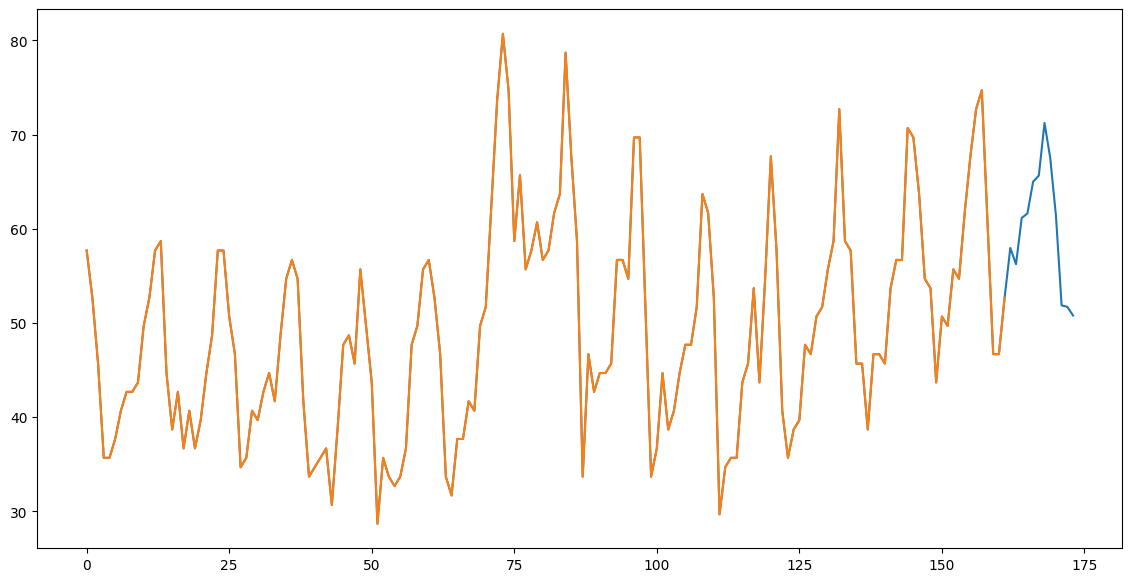

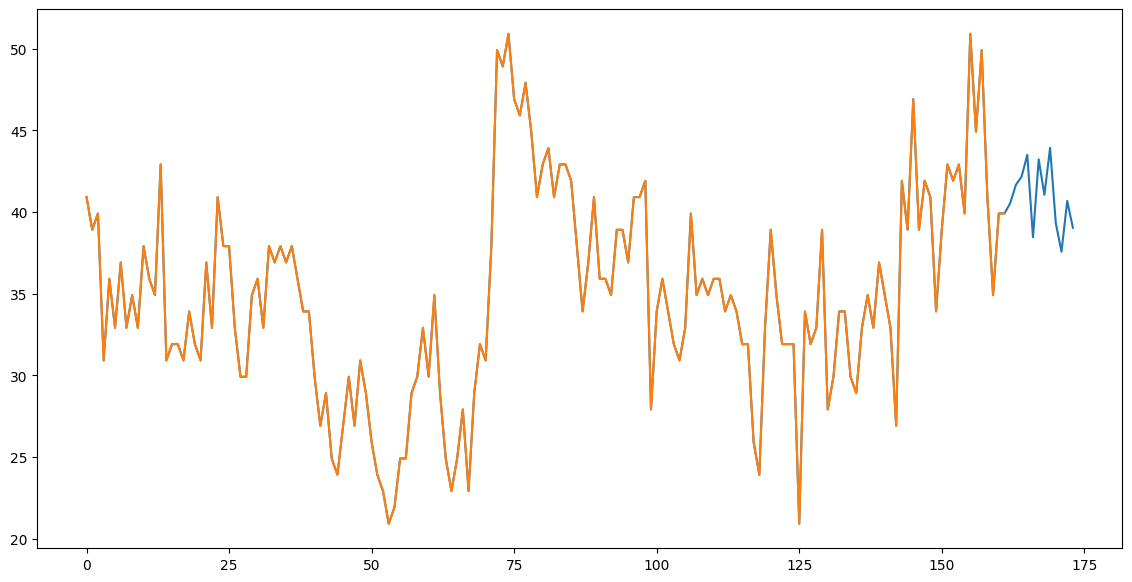

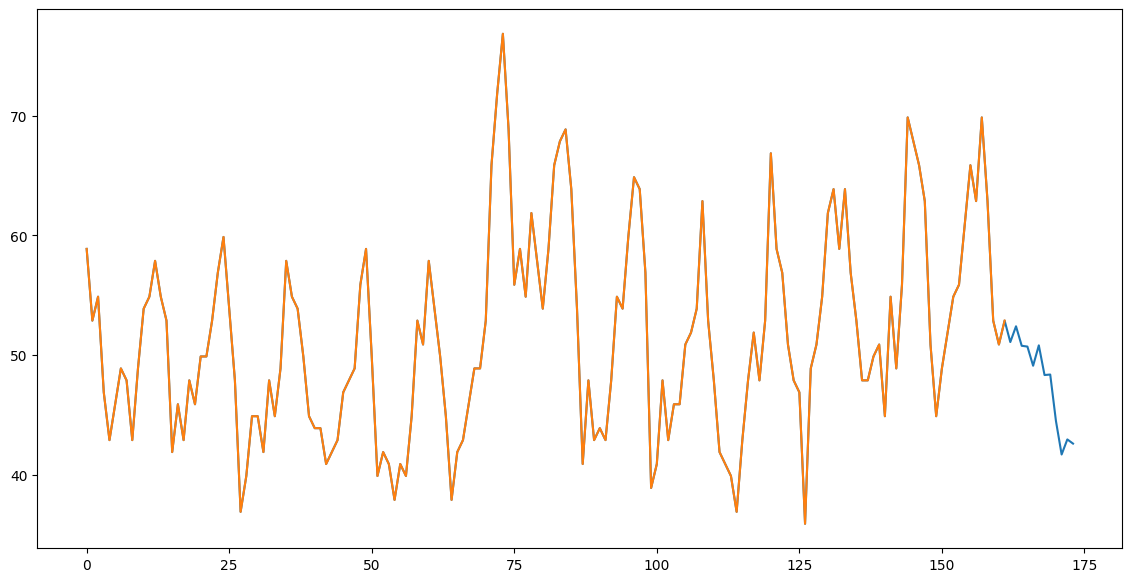

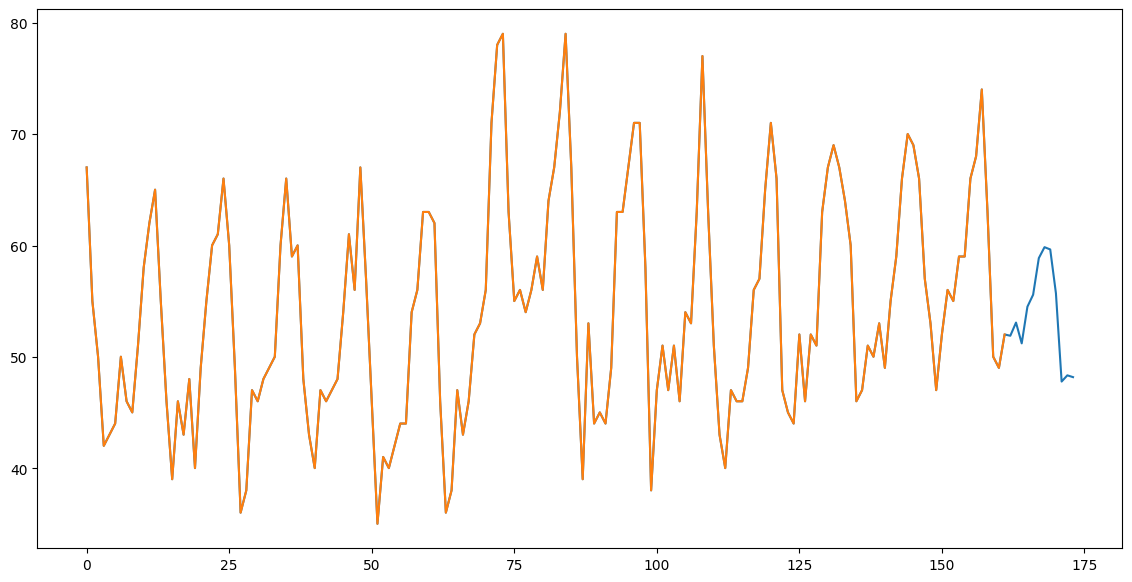

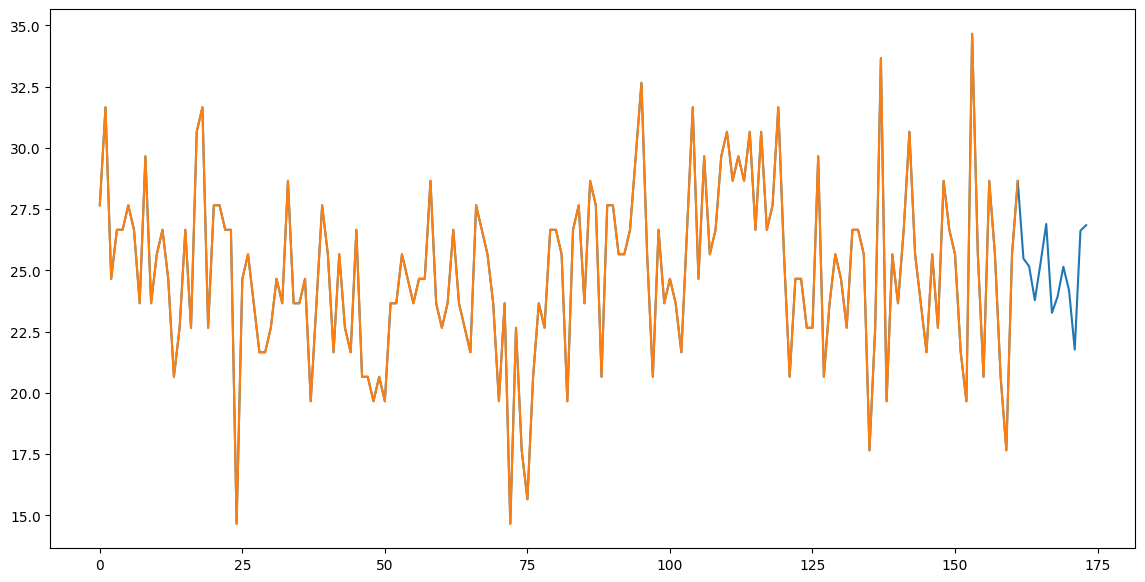

 80%|████████  | 8/10 [00:04<00:01,  1.27it/s]

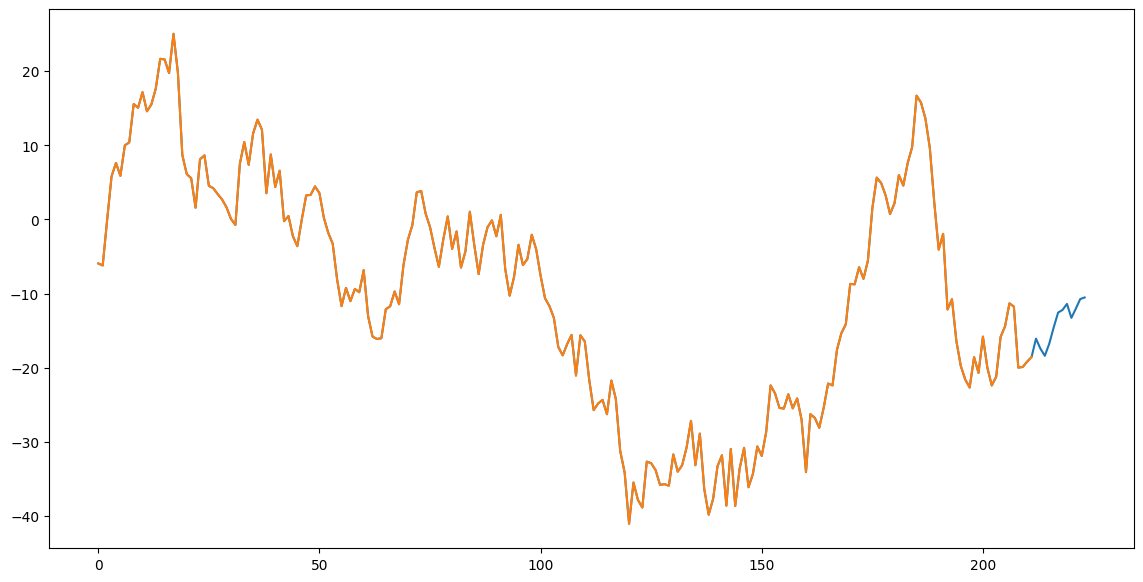

 90%|█████████ | 9/10 [00:04<00:00,  1.66it/s]

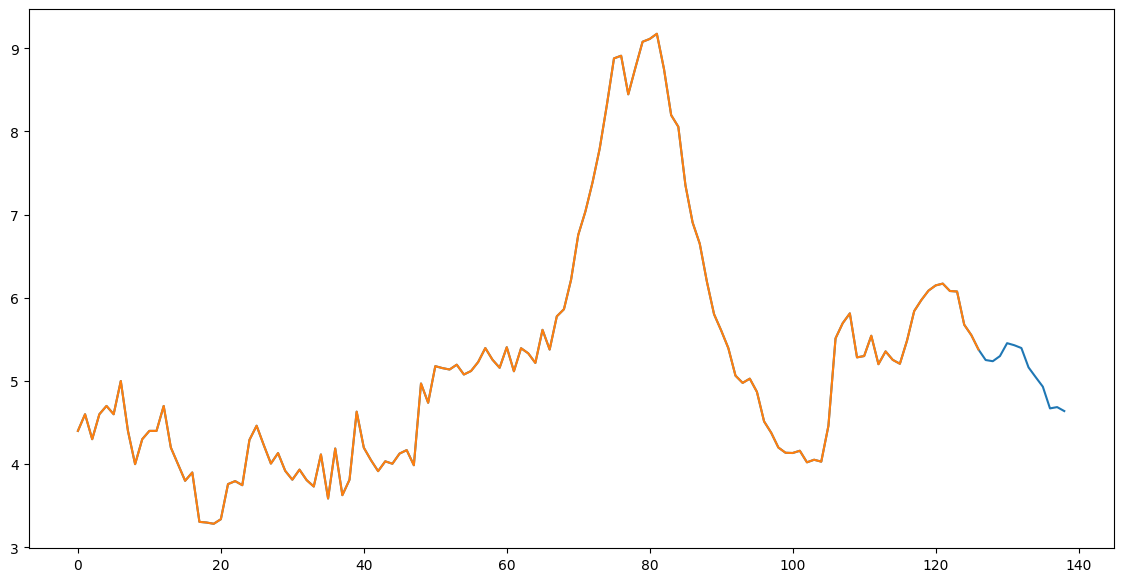

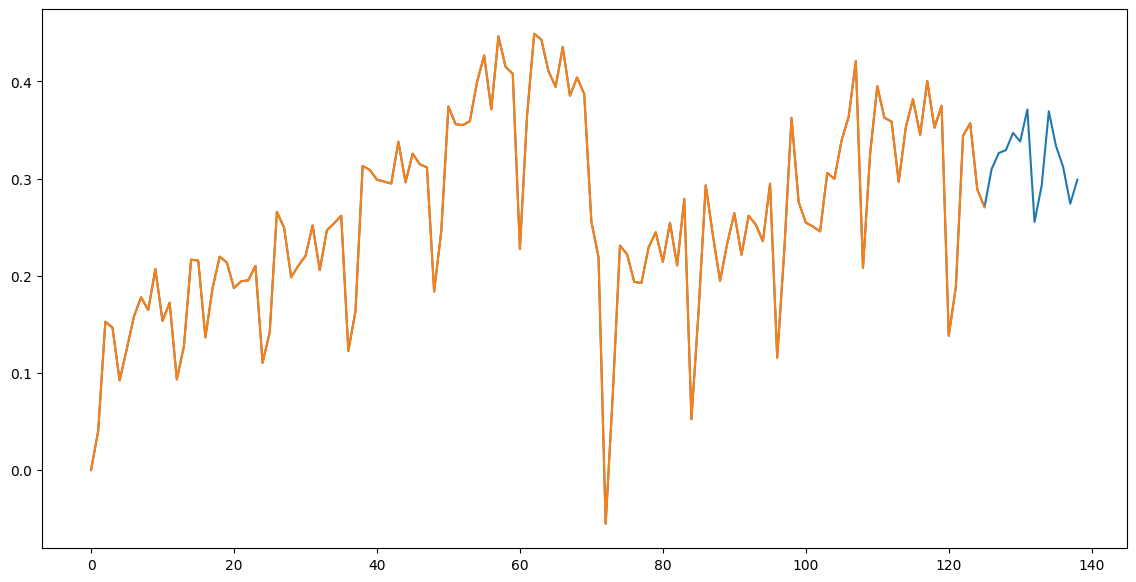

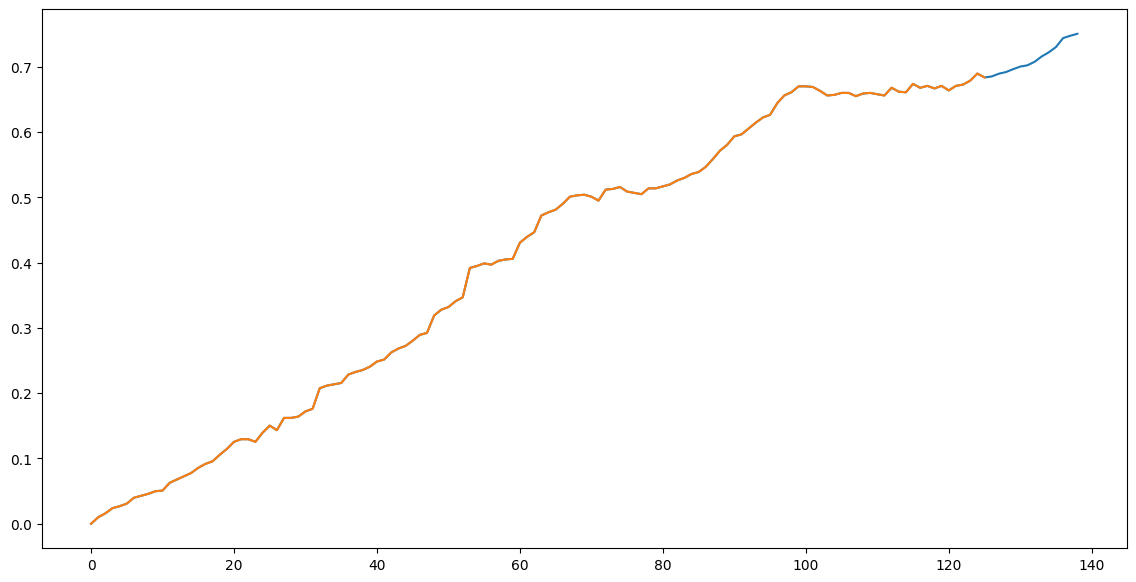

100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


In [5]:
from calendar import month
from tracemalloc import start
from tqdm import tqdm


for x in tqdm(range(0, 10)):
    test_month_df = pd.ExcelFile(f'data/inference_data/test_input/Test_input_{x}.xlsx')
    
    with pd.ExcelWriter(f'data/inference_data/submit/Test_output_{x}.xlsx') as writer:

        if 'Monthly' in test_month_df.sheet_names:
            monthly_df = test_month_df.parse(sheet_name='Monthly')
            monthly_df = monthly_df.set_index('Unnamed: 0')
            monthly_df.index.name = None

            for col in sorted(monthly_df.columns.tolist()):
                if 'Var' in col:
                    start_values = monthly_df[monthly_df[col]!='Forecast'][col].tolist()
                    
                    cur_std = np.std(start_values)
                    cur_mean = np.mean(start_values)
                    
                    if len(start_values) == len(monthly_df):
                        continue
                    
                    new_values = ((np.array(start_values) - cur_mean) / cur_std).tolist()

                    pr = np.zeros(5)
                    for model in clas_month_model:
                        pr += model.predict_proba(make_features_month_clas(new_values))
                    regression_model = models_month_reg[pr.argmax()]
                    
                    a = []
                    for m in range(len(monthly_df[monthly_df[col]=='Forecast'])):
                        pr = 0
                        for model in regression_model:
                            pr += model.predict(make_features_month_reg(new_values))
                        pred = new_values[-1]+pr/5
                        new_values.append(pred)
                        a.append(pred)

                    a = np.array(a) * cur_std + cur_mean

                    monthly_df.loc[monthly_df[col]=='Forecast', col] = a

                    plt.plot([l for l in range(len(start_values)+len(a))], start_values+a.tolist())
                    plt.plot([l for l in range(len(start_values))], start_values)
                    plt.show()
                    
            monthly_df.to_excel(writer, sheet_name='Monthly')

        if 'Quarterly' in test_month_df.sheet_names:
            quarterly_df = test_month_df.parse(sheet_name='Quarterly')
            quarterly_df = quarterly_df.set_index('Unnamed: 0')
            quarterly_df.index.name = None

            for col in sorted(quarterly_df.columns.tolist()):
                if 'Var' in col:
                    start_values = quarterly_df[quarterly_df[col]!='Forecast'][col].tolist()
                    
                    cur_std = np.std(start_values)
                    cur_mean = np.mean(start_values)
                    
                    if len(start_values) == len(quarterly_df):
                        continue
                    
                    new_values = ((np.array(start_values) - cur_mean) / cur_std).tolist()
                    
                    pr = np.zeros(4)
                    for model in clas_quart:
                        pr += model.predict_proba(make_features_quart_clas(new_values))
                    regression_model = models_quart_reg[pr.argmax()]
                    
                    a = []
                    for m in range(len(quarterly_df[quarterly_df[col]=='Forecast'])):
                        pr = 0
                        for model in regression_model:
                            pr += model.predict(make_features_quart_reg(new_values))
                        pred = new_values[-1]+pr/5
                        new_values.append(pred)
                        a.append(pred)
                        
                    a = np.array(a) * cur_std + cur_mean
                        
                    quarterly_df.loc[quarterly_df[col]=='Forecast', col] = a
                    
                    # plt.plot([l for l in range(len(start_values)+len(a))], start_values+a.tolist())
                    # plt.plot([l for l in range(len(start_values))], start_values)
                    # plt.show()
                    
            quarterly_df.to_excel(writer, sheet_name='Quarterly')